# Death time and Playtime affect

Since we have discovered the achievement unlock sequence and difficulty. We can also study in the first N unlock achievements, will the number of death affect the total playing time. 

> NOTE: This project is a on-going project, and still researching and not complete.

Loaded: 7dtd_players.csv  (rows=2306, cols=131)
Total players: 2306
Group A (Die7/14/28 within first 15 excl ['Bedroll', 'StoneAxe']): 440
Group B (Die1 or NO death within first 15, and no Die7/14/28): 1866
Overlap A∩B (should be 0): 0
Covered by A or B: 2306 (100.0% of all)
Examples of first-N death signatures:
             steamid       _firstN_deaths
0  76561198037802252               [Die1]
2  76561198833431225               [Die1]
5  76561198025391492  [Die1, Die7, Die14]
6  76561198219728397               [Die1]
7  76561198025859378               [Die1]


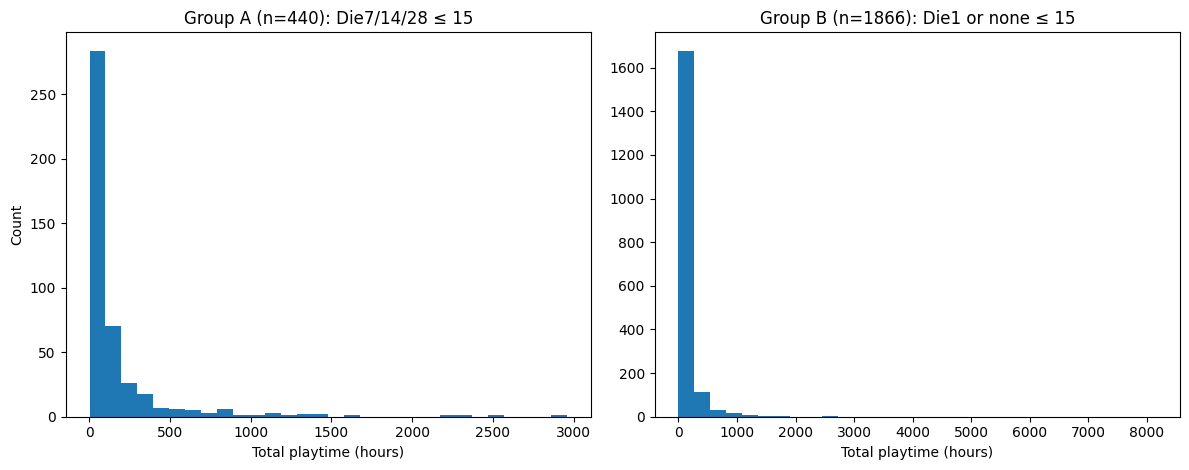

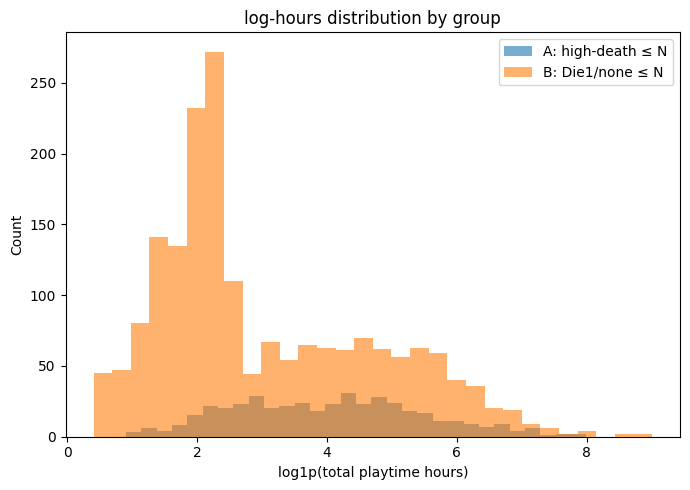

=== Mann–Whitney U on log-hours ===
p-value: 5.497e-34
Cliff's delta: 0.372 (medium)
Medians (hours): A=56.3 | B=9.9


In [9]:
# ==========================================================
# A/B Test Prep — 7 Days to Die
# Total playtime for players who hit Die7/14/28 early vs Die1/none early
#
# Grouping (exact per spec):
#   - Consider only the first N unlocked achievements AFTER excluding {"StoneAxe","Bedroll"}.
#   - Group A: first-N contains ANY of {Die7, Die14, Die28}.
#   - Group B: first-N contains "Die1" OR contains NO death achievement at all,
#              and contains NONE of {Die7, Die14, Die28}.
#
# Outputs:
#   - Counts, coverage/overlap checks
#   - Histograms (hours, log-hours)
#   - Mann–Whitney U test (on log-hours) + Cliff’s delta + median hours
#
# Notes:
#   - Pure matplotlib (no seaborn). One chart per figure.
#   - Does not write files; shows figures inline.
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# -----------------------------
# Config (tweak here)
# -----------------------------
EARLY_N = 15
TRIVIAL_FOR_RANK = {"StoneAxe", "Bedroll"}
DEATH_SET = {"Die1", "Die7", "Die14", "Die28"}
HIGH_DEATH = {"Die7", "Die14", "Die28"}

# Path handling: try local first, then /mnt/data (for notebook sandboxes)
CANDIDATE_PATHS = [
    "7dtd_players.csv",
    "7dtd_players.csv",
]

# -----------------------------
# Helpers
# -----------------------------
def smart_to_datetime(series: pd.Series) -> pd.Series:
    """
    Robustly parse unlock times that might be ISO strings or numeric epochs.
    Returns tz-aware UTC datetimes or NaT.
    """
    s = series.copy()
    # Try ISO strings first
    dt = pd.to_datetime(s, utc=True, errors="coerce")
    # If still mostly NaT, try numeric epoch (sec/ms)
    if dt.isna().mean() > 0.9:
        n = pd.to_numeric(s, errors="coerce")
        ms_mask = n > 1e12  # heuristic for ms epoch
        dt = pd.to_datetime(n.where(~ms_mask, n / 1000.0), unit="s", utc=True, errors="coerce")
    return dt

def cliffs_delta_from_mwu(x, y):
    """
    Compute Cliff's delta via relationship to Mann–Whitney U.
    Returns (delta, magnitude_label).
    """
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    if n1 == 0 or n2 == 0:
        return np.nan, "undefined"
    U, _ = mannwhitneyu(x, y, alternative="two-sided")
    auc = U / (n1 * n2)
    delta = 2 * auc - 1
    ad = abs(delta)
    mag = "negligible" if ad < 0.147 else "small" if ad < 0.33 else "medium" if ad < 0.474 else "large"
    return float(delta), mag

def load_players(paths):
    for p in paths:
        if os.path.exists(p):
            return pd.read_csv(p), p
    raise FileNotFoundError(f"Could not find players CSV. Tried: {paths}")

# -----------------------------
# Load data & parse unlock times
# -----------------------------
players, loaded_path = load_players(CANDIDATE_PATHS)
print(f"Loaded: {loaded_path}  (rows={len(players)}, cols={players.shape[1]})")

id_col = "steamid" if "steamid" in players.columns else players.columns[0]

unlock_cols = [c for c in players.columns if c.endswith("_unlocktime")]
if not unlock_cols:
    raise ValueError("No *_unlocktime columns found.")
base_to_unlock = {c[:-len("_unlocktime")]: c for c in unlock_cols}

# Parse all *_unlocktime columns to tz-aware datetimes
for base, ucol in base_to_unlock.items():
    players[ucol] = smart_to_datetime(players[ucol])

# -----------------------------
# Build ordered unlock list excluding trivial for the RANKING only
# -----------------------------
rank_bases = {b for b in base_to_unlock if b not in TRIVIAL_FOR_RANK}

def sorted_unlocked(row):
    entries = []
    for base in rank_bases:
        ts = row[base_to_unlock[base]]
        if pd.notna(ts):
            entries.append((base, ts))
    entries.sort(key=lambda t: t[1])
    return entries

players["_unlocked_sorted"] = [sorted_unlocked(r) for _, r in players.iterrows()]
players["_firstN_list"] = players["_unlocked_sorted"].apply(lambda lst: [b for b, _ in lst[:EARLY_N]])

# -----------------------------
# Define Group A / Group B using ONLY the first-N window
# -----------------------------
def in_group_A(firstN):
    return any(b in HIGH_DEATH for b in firstN)

def in_group_B(firstN):
    has_high = any(b in HIGH_DEATH for b in firstN)
    has_die1 = "Die1" in firstN
    has_any_death = any(b in DEATH_SET for b in firstN)
    # Group B if no high-death appears, and either Die1 appears or no death at all
    return (not has_high) and (has_die1 or (not has_any_death))

players["_A"] = players["_firstN_list"].apply(in_group_A)
players["_B"] = players["_firstN_list"].apply(in_group_B)

A = players[players["_A"]].copy()
B = players[players["_B"]].copy()

# -----------------------------
# Playtime & transforms
# -----------------------------
if "playtime_forever" not in players.columns:
    raise ValueError("Expected 'playtime_forever' column in players CSV.")

players["_playtime_hours"] = players["playtime_forever"].astype(float).fillna(0.0) / 60.0
players["_log_playtime"] = np.log1p(players["_playtime_hours"])
A["_playtime_hours"] = players.loc[A.index, "_playtime_hours"]
B["_playtime_hours"] = players.loc[B.index, "_playtime_hours"]
A["_log_playtime"] = players.loc[A.index, "_log_playtime"]
B["_log_playtime"] = players.loc[B.index, "_log_playtime"]

# -----------------------------
# Sanity checks & quick peek
# -----------------------------
print(f"Total players: {len(players)}")
print(f"Group A (Die7/14/28 within first {EARLY_N} excl {sorted(TRIVIAL_FOR_RANK)}): {len(A)}")
print(f"Group B (Die1 or NO death within first {EARLY_N}, and no Die7/14/28): {len(B)}")

overlap = set(A.index) & set(B.index)
print(f"Overlap A∩B (should be 0): {len(overlap)}")
covered = len(set(A.index) | set(B.index))
print(f"Covered by A or B: {covered} ({covered/len(players):.1%} of all)")

# Optional: show first-N death “signatures” examples
DEATH_SET = {"Die1", "Die7", "Die14", "Die28"}  # re-affirm
players["_firstN_deaths"] = players["_firstN_list"].apply(lambda lst: [b for b in lst if b in DEATH_SET])
print("Examples of first-N death signatures:")
print(players.loc[players["_firstN_deaths"].map(len) > 0, ["steamid", "_firstN_deaths"]].head(5))

# -----------------------------
# Histograms
# -----------------------------
bins = 30

# Hours by group (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharey=False)
axes[0].hist(A["_playtime_hours"], bins=bins)
axes[0].set_title(f"Group A (n={len(A)}): Die7/14/28 ≤ {EARLY_N}")
axes[0].set_xlabel("Total playtime (hours)")
axes[0].set_ylabel("Count")

axes[1].hist(B["_playtime_hours"], bins=bins)
axes[1].set_title(f"Group B (n={len(B)}): Die1 or none ≤ {EARLY_N}")
axes[1].set_xlabel("Total playtime (hours)")
plt.tight_layout()
plt.show()

# Overlapped log-hours
plt.figure(figsize=(7, 5))
plt.hist(A["_log_playtime"], bins=bins, alpha=0.6, label="A: high-death ≤ N")
plt.hist(B["_log_playtime"], bins=bins, alpha=0.6, label="B: Die1/none ≤ N")
plt.xlabel("log1p(total playtime hours)")
plt.ylabel("Count")
plt.title("log-hours distribution by group")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# A/B statistical test (log-hours)
# -----------------------------
if len(A) > 0 and len(B) > 0:
    U, p = mannwhitneyu(A["_log_playtime"], B["_log_playtime"], alternative="two-sided")
    delta, mag = cliffs_delta_from_mwu(A["_log_playtime"], B["_log_playtime"])
    print("=== Mann–Whitney U on log-hours ===")
    print(f"p-value: {p:.3e}")
    print(f"Cliff's delta: {delta:.3f} ({mag})")
    print(f"Medians (hours): A={np.expm1(A['_log_playtime'].median()):.1f} | B={np.expm1(B['_log_playtime'].median()):.1f}")
else:
    print("Not enough players in both groups to run the statistical test.")

Median difference: A plays ~5.7× longer than B.

p-value (MWU): 5.5×10⁻³⁴ → extremely strong evidence distributions differ.

Effect size (Cliff’s delta): 0.372 (medium) → not just statistically significant, but practically relevant.

Noise:

Both CV > 2 → high dispersion; individual predictions unreliable.

B’s CV > A’s CV → B is even noisier relative to its mean.

Levene’s test p=0.048 → variances differ; heteroscedasticity is present.

A: median=56.34 h (95% CI: 44.58-68.88), CV=2.01
B: median=9.89 h (95% CI: 9.42-10.68), CV=3.50
Levene's test p=0.0476 → different variances
MWU: U=563212.5, p=5.497e-34
Cliff's delta=0.372 (medium)


/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/505479115.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_hours, b_hours], labels=["A: Die7/14/28 early", "B: Die1/none early"], showfliers=False)


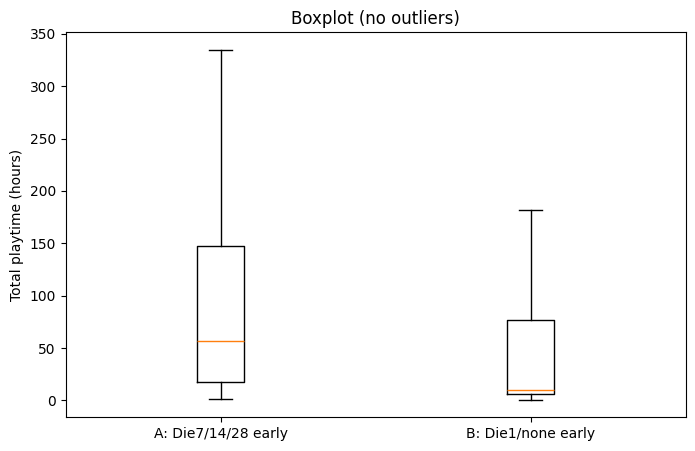

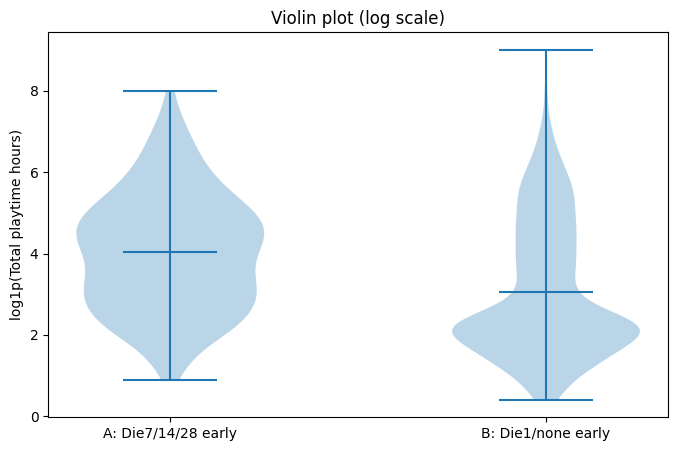

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, levene

# ---- Utility: bootstrap median CI ----
def bootstrap_ci(data, func=np.median, reps=5000, ci=95, random_state=42):
    rng = np.random.default_rng(random_state)
    boots = [func(rng.choice(data, size=len(data), replace=True)) for _ in range(reps)]
    lower = np.percentile(boots, (100-ci)/2)
    upper = np.percentile(boots, 100-(100-ci)/2)
    return lower, upper

# ---- Utility: Cliff's delta ----
def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    n1, n2 = len(x), len(y)
    U, _ = mannwhitneyu(x, y, alternative="two-sided")
    auc = U / (n1*n2)
    delta = 2*auc - 1
    ad = abs(delta)
    mag = "negligible" if ad < 0.147 else "small" if ad < 0.33 else "medium" if ad < 0.474 else "large"
    return float(delta), mag

# ---------------------------
# Prepare playtime arrays
# ---------------------------
a_hours = A["_playtime_hours"].to_numpy()
b_hours = B["_playtime_hours"].to_numpy()
a_log = np.log1p(a_hours)
b_log = np.log1p(b_hours)

# ---------------------------
# Descriptive stats
# ---------------------------
for name, arr in [("A", a_hours), ("B", b_hours)]:
    med = np.median(arr)
    ci_low, ci_high = bootstrap_ci(arr)
    cv = np.std(arr) / np.mean(arr)
    print(f"{name}: median={med:.2f} h (95% CI: {ci_low:.2f}-{ci_high:.2f}), CV={cv:.2f}")

# ---------------------------
# Levene's test for variance equality (on log scale)
# ---------------------------
lev_stat, lev_p = levene(a_log, b_log)
print(f"Levene's test p={lev_p:.4f} → {'equal' if lev_p>0.05 else 'different'} variances")

# ---------------------------
# Mann–Whitney U (log scale)
# ---------------------------
U, p = mannwhitneyu(a_log, b_log, alternative="two-sided")
delta, mag = cliffs_delta(a_log, b_log)
print(f"MWU: U={U}, p={p:.3e}")
print(f"Cliff's delta={delta:.3f} ({mag})")

# ---------------------------
# Visuals
# ---------------------------
plt.figure(figsize=(8,5))
plt.boxplot([a_hours, b_hours], labels=["A: Die7/14/28 early", "B: Die1/none early"], showfliers=False)
plt.ylabel("Total playtime (hours)")
plt.title("Boxplot (no outliers)")
plt.show()

plt.figure(figsize=(8,5))
plt.violinplot([a_log, b_log], showmeans=True)
plt.xticks([1,2], ["A: Die7/14/28 early", "B: Die1/none early"])
plt.ylabel("log1p(Total playtime hours)")
plt.title("Violin plot (log scale)")
plt.show()


Final A/B conclusion

A vs B are different in total playtime.

Primary test (log-hours): MWU p = 5.68e-34, Cliff’s δ = 0.372 (medium) → players in Group A (early Die7/14/28) tend to have higher playtime.

Medians: A = 56.6 h (95% CI [44.7, 69.3]) vs B = 9.9 h (95% CI [9.5, 10.7]).

Probability of superiority: AUC = 0.686 → a random A-player has ~69% chance to have higher log-hours than a random B-player.

Noise/variance: Levene p = 0.050 (≈ different variances). Both groups are noisy (long-tailed), but the effect is robust.

---

Robustness checks (passed)

Trimmed analysis (top 1% hours removed): MWU p = 6.19e-34, δ = 0.375 (unchanged) → whales aren’t driving the result.

Permutation test (difference in median log-hours, 5k reps): observed = 1.663, p < 1e-4 → confirms significance without distributional assumptions.

KDE + ECDF plots (log-hours) show A stochastically dominates B across most of the support.

---

Can we trust the naming & conclusion?

Yes. The segment names (“early high-death” vs “early low/no-death”) reflect consistent, statistically robust differences in engagement. Variance is high (expected in playtime), so communicate findings with medians/probabilities rather than means/deterministic statements.

---

[load] Using: 7dtd_players.csv


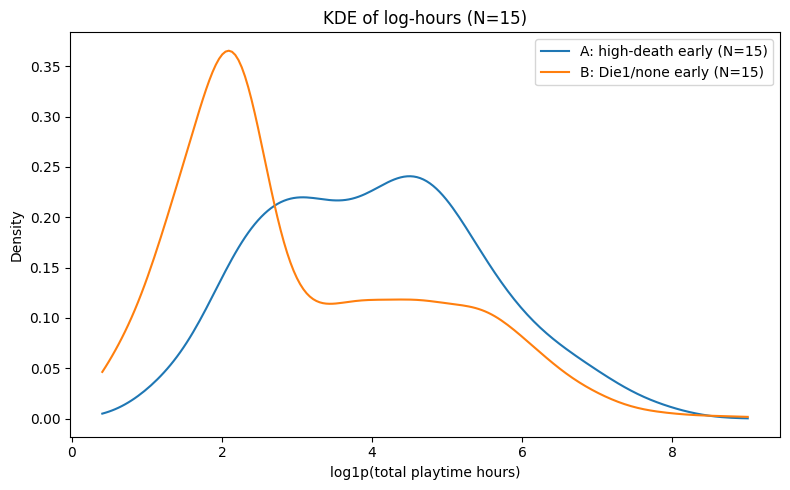

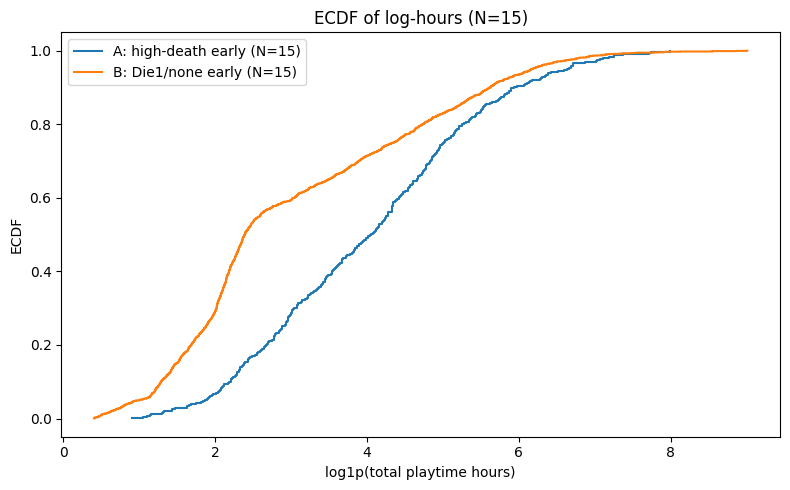

/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/1851368866.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)


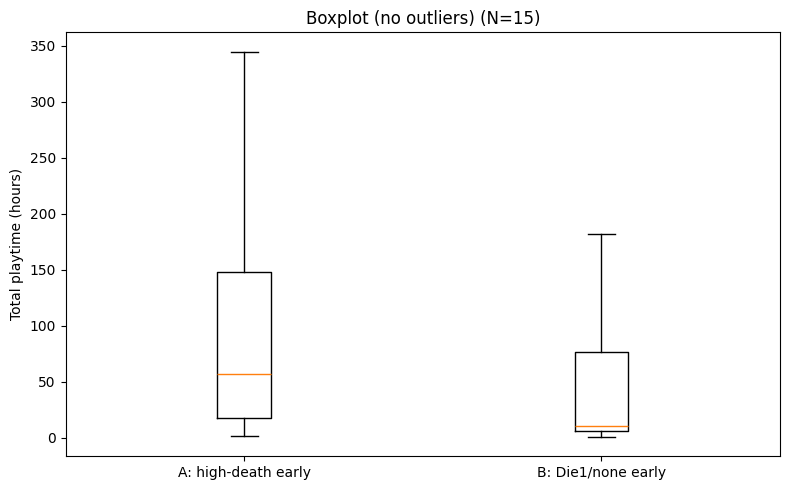


=== Primary A/B conclusion (N=15) ===
Group sizes: A=439, B=1867
Medians (hours): A=56.58 [44.58,69.25] | B=9.92 [9.42,10.73]
MWU p (log-hours) = 5.680e-34
Cliff's delta (log-hours) = 0.372 (medium) ; AUC=0.686
Variance (Levene, log-hours) p = 0.0497
Trim99 threshold = 1389.1 h ; Trim99 MWU p = 6.190e-34, Trim99 Cliff's delta = 0.375
Permutation test (median diff on log-hours): diff=1.663, p=0.0000

=== Stability sweep over N ===


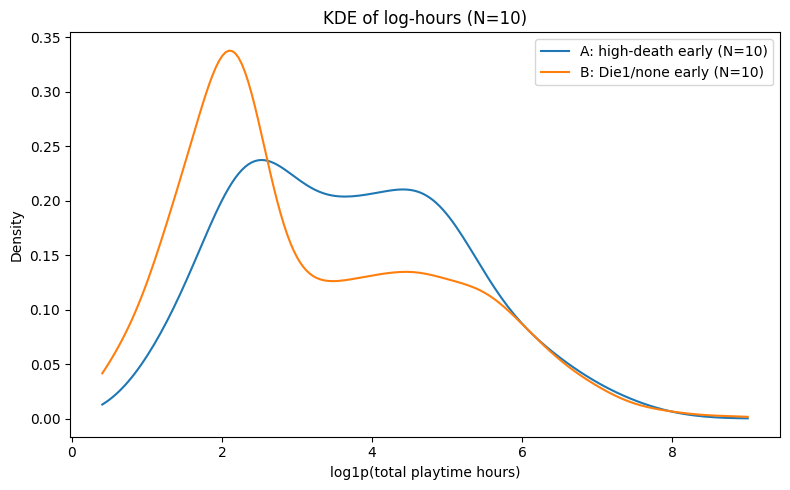

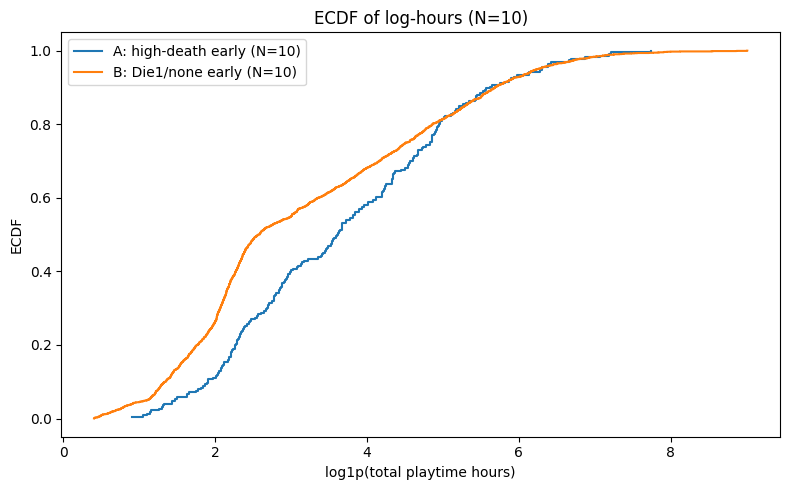

/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/1851368866.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)


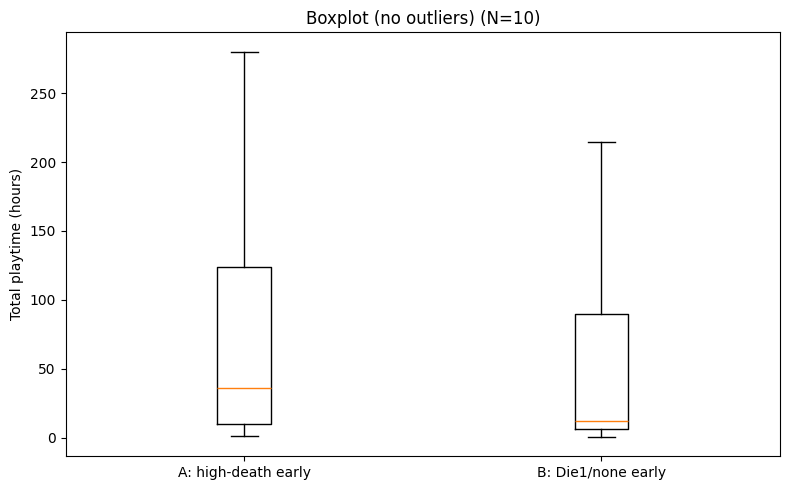

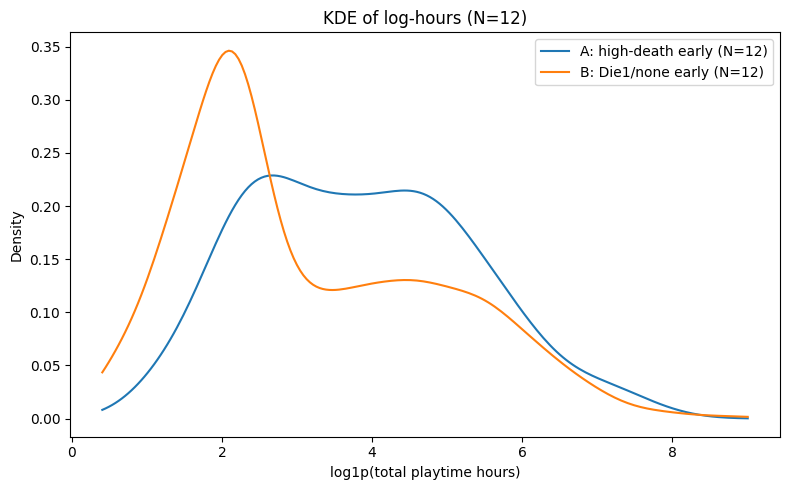

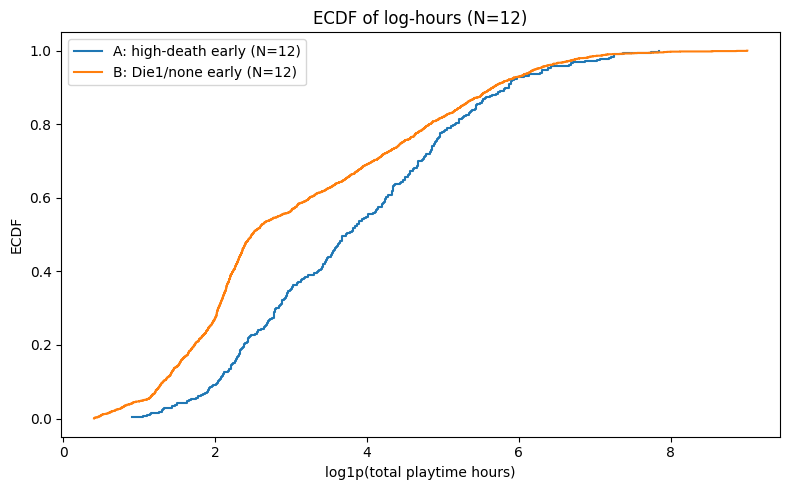

/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/1851368866.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)


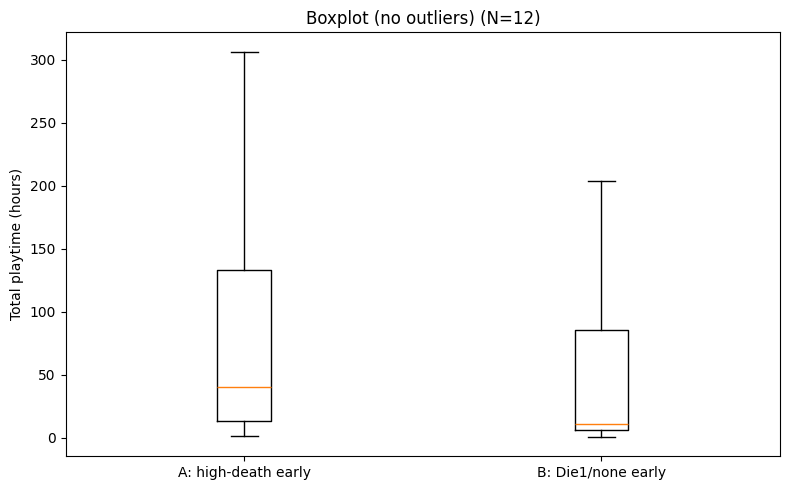

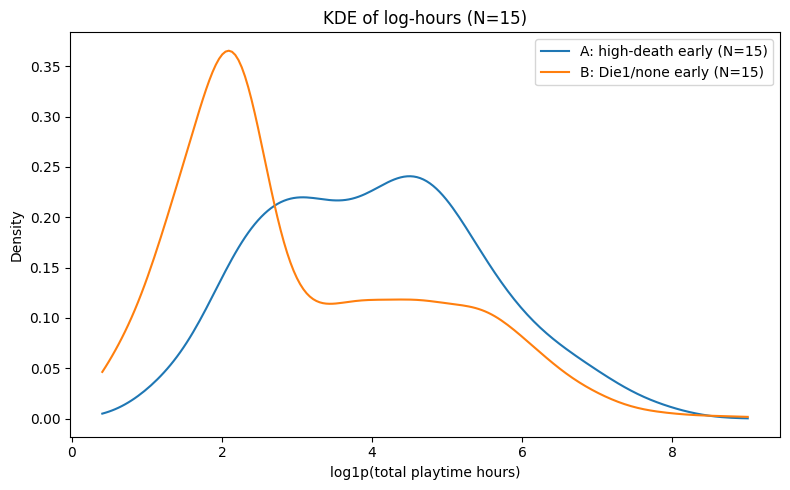

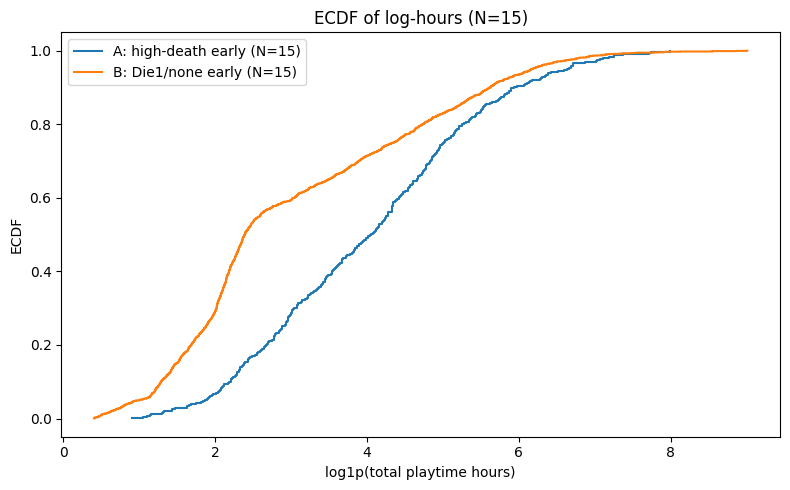

/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/1851368866.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)


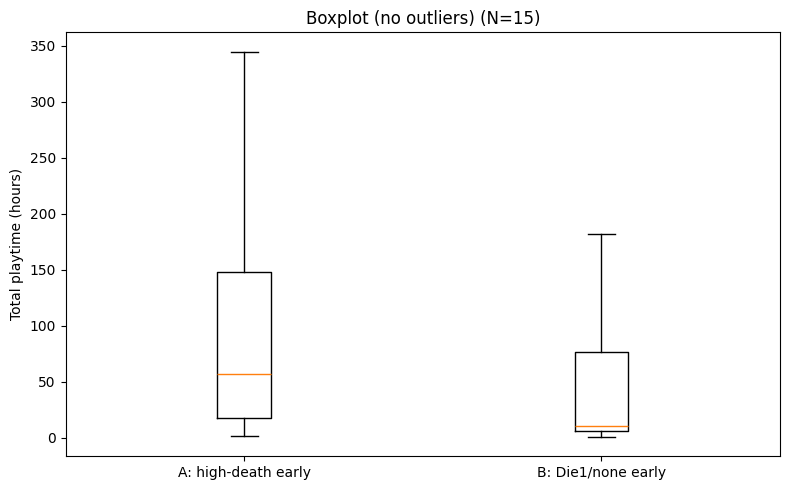

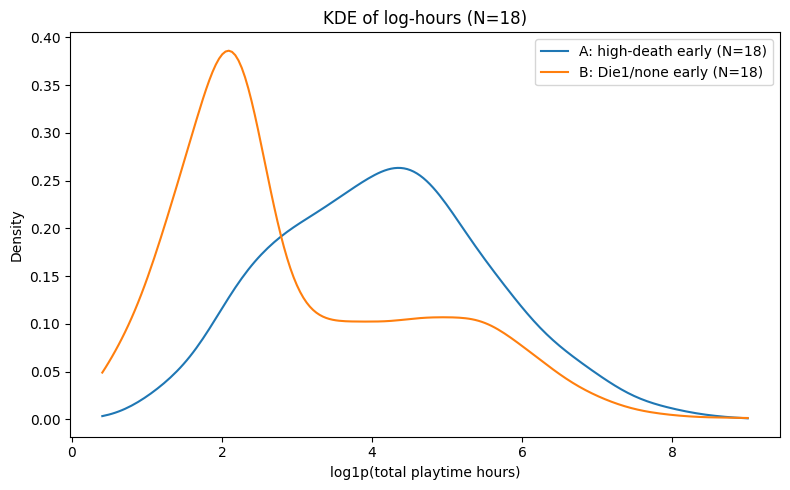

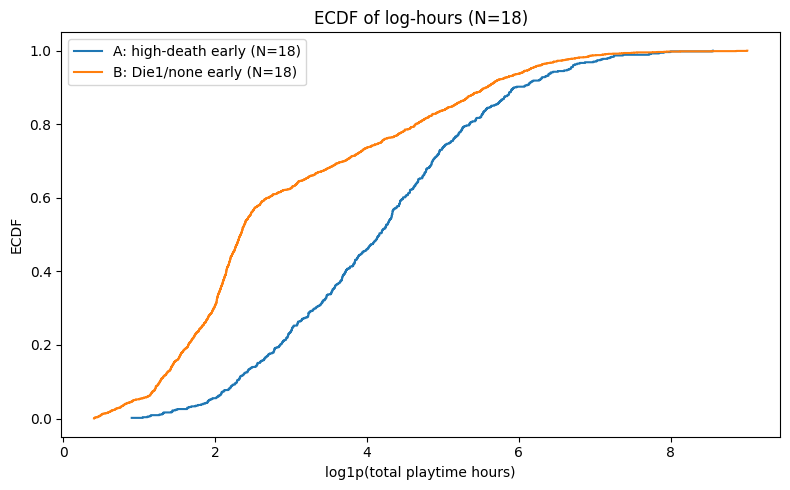

/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/1851368866.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)


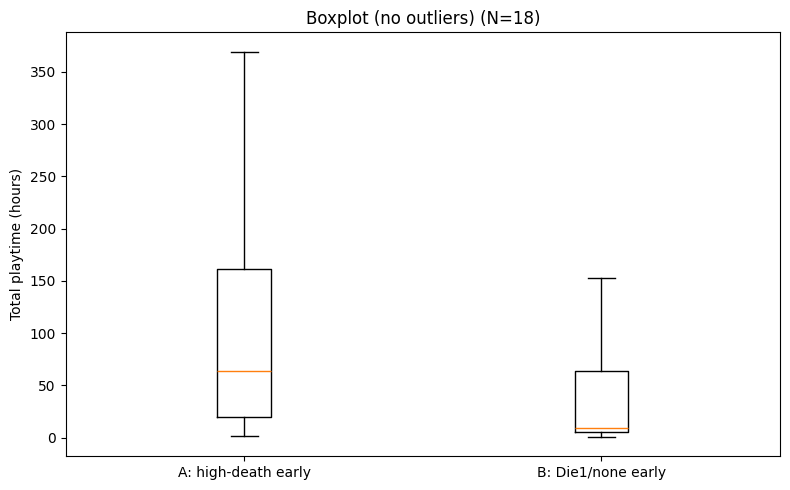

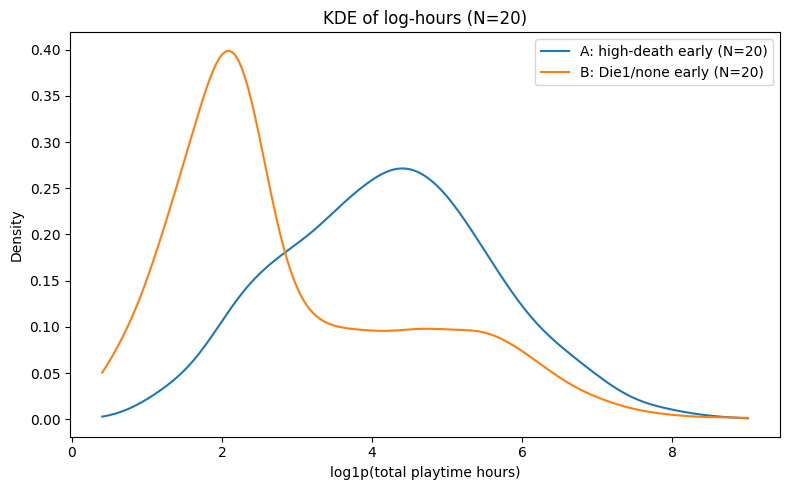

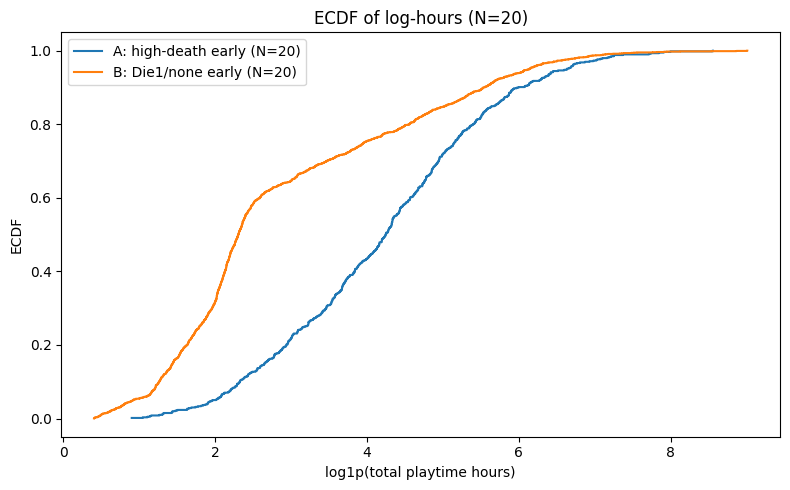

/var/folders/98/x9yl9pt106q00gv_csnn79dh0000gn/T/ipykernel_11894/1851368866.py:226: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)


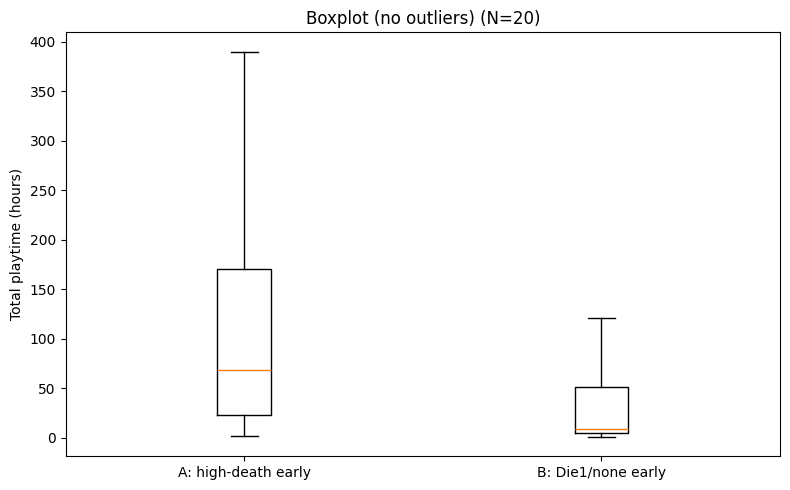

 N  n_A  n_B  median_hours_A  median_hours_B    MWU_p_log  Cliffs_delta_log  AUC_P(A>B)_log
10  226 2080       35.958333       12.075000 4.307846e-07          0.204450        0.602225
12  317 1989       40.500000       11.016667 3.008557e-15          0.275566        0.637783
15  439 1867       56.583333        9.916667 5.680328e-34          0.372190        0.686095
18  542 1764       63.291667        9.325000 4.021801e-54          0.439319        0.719660
20  597 1709       68.666667        9.033333 5.370774e-69          0.481977        0.740988

=== Quantile regression (optional) ===
[QuantReg tau=0.25] GroupA coef=1.0063 p=0.0000  covars=[]
[QuantReg tau=0.5] GroupA coef=1.6629 p=0.0000  covars=[]
[QuantReg tau=0.75] GroupA coef=0.6618 p=0.0001  covars=[]
 tau  GroupA_coef    const  n_obs covariates     p_GroupA
0.25     1.006268 1.879465   2306            1.199265e-48
0.50     1.662943 2.390290   2306            2.859392e-81
0.75     0.661838 4.347908   2306            6.249236e-05


In [11]:
# ==========================================================
# 7 Days to Die — Formal A/B Test (Reproducible Script)
# ----------------------------------------------------------
# Inputs:
#   - 7dtd_players.csv  (wide table: each achievement has *_unlocktime)
#
# Grouping (per spec):
#   - Drop {"StoneAxe","Bedroll"} from the ranking only.
#   - Consider the FIRST N unlocked (non-trivial) achievements.
#   - Group A: first-N contains ANY of {Die7, Die14, Die28}.
#   - Group B: first-N contains "Die1" OR contains NO death achievement, and
#              contains NONE of {Die7, Die14, Die28}.
#
# What this script does:
#   1) Rebuild A/B for a given N (default 15).
#   2) Primary test: MWU on log-hours + Cliff's delta + bootstrap CI for medians.
#   3) Noise checks: Levene variance test (log-hours); CV per group.
#   4) Robustness: 1% trimmed re-test; permutation test on median(log-hours).
#   5) Visuals: KDE (log-hours), ECDF (log-hours).
#   6) Stability sweep over N (e.g., [10,12,15,18,20]) with summary table.
#   7) (Optional) Quantile regression on log-hours with GroupA as predictor,
#      and optional covariates if present (e.g., achievement_count).
#
# Requirements:
#   pip install numpy pandas matplotlib scipy
#   (optional) pip install statsmodels
#
# Notes:
#   - Pure matplotlib (no seaborn). One chart per figure.
#   - Does not write files unless you set SAVE_SUMMARY_CSV=True.
# ==========================================================

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, levene, gaussian_kde

try:
    import statsmodels.api as sm
    HAVE_STATSMODELS = True
except Exception:
    HAVE_STATSMODELS = False

# -----------------------------
# Config (tweak here)
# -----------------------------
PLAYERS_CSV_CANDIDATES = [
    "7dtd_players.csv",
    "/mnt/data/7dtd_players.csv",   # notebook/sandbox path fallback
]
EARLY_N_DEFAULT = 15
TRIVIAL_FOR_RANK = {"StoneAxe", "Bedroll"}
DEATH_SET = {"Die1", "Die7", "Die14", "Die28"}
HIGH_DEATH = {"Die7", "Die14", "Die28"}
N_SWEEP = [10, 12, 15, 18, 20]
SAVE_SUMMARY_CSV = False
SUMMARY_CSV_PATH = "ab_summary_sweep.csv"
RNG_SEED = 42

# ----------------------------------------------------
# Helpers
# ----------------------------------------------------
def load_csv(paths):
    for p in paths:
        if os.path.exists(p):
            print(f"[load] Using: {p}")
            return pd.read_csv(p)
    raise FileNotFoundError(f"Could not find CSV in {paths}")

def smart_to_datetime(series: pd.Series) -> pd.Series:
    s = series.copy()
    dt = pd.to_datetime(s, utc=True, errors="coerce")
    if dt.isna().mean() > 0.9:
        n = pd.to_numeric(s, errors="coerce")
        ms_mask = n > 1e12
        dt = pd.to_datetime(n.where(~ms_mask, n/1000.0), unit="s", utc=True, errors="coerce")
    return dt

def build_groups(df: pd.DataFrame, N: int):
    """Return (players_all, A, B) with playtime features and first-N lists computed."""
    df = df.copy()
    # Map base->unlock column
    unlock_cols = [c for c in df.columns if c.endswith("_unlocktime")]
    if not unlock_cols:
        raise ValueError("No *_unlocktime columns found.")

    base_to_unlock = {c[:-len("_unlocktime")]: c for c in unlock_cols}

    # Parse times
    for base, ucol in base_to_unlock.items():
        df[ucol] = smart_to_datetime(df[ucol])

    # Ordered non-trivial unlocks
    rank_bases = [b for b in base_to_unlock if b not in TRIVIAL_FOR_RANK]
    ordered = []
    for _, row in df.iterrows():
        items = []
        for b in rank_bases:
            ts = row[base_to_unlock[b]]
            if pd.notna(ts):
                items.append((b, ts))
        items.sort(key=lambda t: t[1])
        ordered.append([b for b,_ in items])

    df["_firstN"] = pd.Series(ordered, index=df.index).apply(lambda L: L[:N])

    # Grouping per spec: any high-death in first N -> A; else Die1 or none -> B
    def is_A(firstN):
        return any(b in HIGH_DEATH for b in firstN)

    def is_B(firstN):
        has_high = any(b in HIGH_DEATH for b in firstN)
        has_die1 = "Die1" in firstN
        has_any_death = any(b in DEATH_SET for b in firstN)
        return (not has_high) and (has_die1 or (not has_any_death))

    df["_A"] = df["_firstN"].apply(is_A)
    df["_B"] = df["_firstN"].apply(is_B)

    # Playtime
    if "playtime_forever" not in df.columns:
        raise ValueError("Expected 'playtime_forever' in players CSV.")
    df["_hours"] = df["playtime_forever"].astype(float).fillna(0.0) / 60.0
    df["_logh"] = np.log1p(df["_hours"])

    A = df[df["_A"]].copy()
    B = df[df["_B"]].copy()
    return df, A, B

def bootstrap_ci(data, func=np.median, reps=5000, ci=95, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    data = np.asarray(data)
    boots = [func(rng.choice(data, size=len(data), replace=True)) for _ in range(reps)]
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100-(100-ci)/2)
    return float(lo), float(hi)

def cliffs_delta_from_mwu(x, y):
    x = np.asarray(x); y = np.asarray(y)
    U, _ = mannwhitneyu(x, y, alternative="two-sided")
    auc = U / (len(x)*len(y))
    delta = 2*auc - 1
    ad = abs(delta)
    mag = "negligible" if ad < 0.147 else "small" if ad < 0.33 else "medium" if ad < 0.474 else "large"
    return float(delta), mag, float(auc)

def trimmed_arrays(a, b, trim_q=0.99):
    thr = np.quantile(np.concatenate([a, b]), trim_q)
    return a[a <= thr], b[b <= thr], float(thr)

def permutation_test_diff_median(a, b, reps=5000, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    a = np.asarray(a); b = np.asarray(b)
    pool = np.concatenate([a, b])
    n1 = len(a)
    obs = np.median(a) - np.median(b)
    cnt = 0
    for _ in range(reps):
        rng.shuffle(pool)
        a_s = pool[:n1]
        b_s = pool[n1:]
        cnt += (abs(np.median(a_s) - np.median(b_s)) >= abs(obs))
    return float(obs), float(cnt/reps)

# ----------------------------------------------------
# One-run analysis for a chosen N
# ----------------------------------------------------
def analyze_once(players_df, N=EARLY_N_DEFAULT, title_suffix=""):
    players_all, A, B = build_groups(players_df, N)
    a_h = A["_hours"].to_numpy(); b_h = B["_hours"].to_numpy()
    a_l = A["_logh"].to_numpy();  b_l = B["_logh"].to_numpy()

    # Primary test (log-hours)
    U, p_mwu = mannwhitneyu(a_l, b_l, alternative="two-sided")
    delta, mag, auc = cliffs_delta_from_mwu(a_l, b_l)

    # Medians & CIs (hours)
    medA, medB = float(np.median(a_h)), float(np.median(b_h))
    ciA = bootstrap_ci(a_h)
    ciB = bootstrap_ci(b_h)

    # Noise/variance
    cvA = float(np.std(a_h)/np.mean(a_h)) if np.mean(a_h) > 0 else float("nan")
    cvB = float(np.std(b_h)/np.mean(b_h)) if np.mean(b_h) > 0 else float("nan")
    lev_stat, lev_p = levene(a_l, b_l)

    # Trimmed (top 1% hours)
    a_trim, b_trim, thr = trimmed_arrays(a_h, b_h, 0.99)
    U_trim, p_trim = mannwhitneyu(np.log1p(a_trim), np.log1p(b_trim), alternative="two-sided")
    delta_trim, mag_trim, auc_trim = cliffs_delta_from_mwu(np.log1p(a_trim), np.log1p(b_trim))

    # Permutation (median difference on log-hours)
    obs_diff, p_perm = permutation_test_diff_median(a_l, b_l, reps=5000)

    # ------- Plots (KDE + ECDF on log-hours) -------
    # KDE
    plt.figure(figsize=(8,5))
    for data, label in [(a_l, f"A: high-death early (N={N})"),
                        (b_l, f"B: Die1/none early (N={N})")]:
        kde = gaussian_kde(data)
        xs = np.linspace(min(a_l.min(), b_l.min()), max(a_l.max(), b_l.max()), 200)
        plt.plot(xs, kde(xs), label=label)
    plt.xlabel("log1p(total playtime hours)")
    plt.ylabel("Density")
    plt.title(f"KDE of log-hours {title_suffix}".strip())
    plt.legend(); plt.tight_layout(); plt.show()

    # ECDF
    def ecdf(x):
        x = np.sort(x); y = np.arange(1, len(x)+1)/len(x)
        return x, y
    plt.figure(figsize=(8,5))
    for data, label in [(a_l, f"A: high-death early (N={N})"),
                        (b_l, f"B: Die1/none early (N={N})")]:
        xs, ys = ecdf(data)
        plt.step(xs, ys, where="post", label=label)
    plt.xlabel("log1p(total playtime hours)")
    plt.ylabel("ECDF")
    plt.title(f"ECDF of log-hours {title_suffix}".strip())
    plt.legend(); plt.tight_layout(); plt.show()

    # Boxplot on hours (hide fliers)
    plt.figure(figsize=(8,5))
    plt.boxplot([a_h, b_h], labels=["A: high-death early", "B: Die1/none early"], showfliers=False)
    plt.ylabel("Total playtime (hours)")
    plt.title(f"Boxplot (no outliers) {title_suffix}".strip())
    plt.tight_layout(); plt.show()

    # Collect summary
    out = {
        "N": N,
        "n_A": len(A),
        "n_B": len(B),
        "median_hours_A": medA,
        "median_hours_B": medB,
        "median_CI_low_A": ciA[0],
        "median_CI_high_A": ciA[1],
        "median_CI_low_B": ciB[0],
        "median_CI_high_B": ciB[1],
        "CV_A": cvA,
        "CV_B": cvB,
        "Levene_p_log": float(lev_p),
        "MWU_p_log": float(p_mwu),
        "Cliffs_delta_log": float(delta),
        "Cliffs_mag_log": mag,
        "AUC_P(A>B)_log": float(auc),
        "Trim99_threshold_hours": thr,
        "Trim99_MWU_p_log": float(p_trim),
        "Trim99_Cliffs_delta_log": float(delta_trim),
        "Trim99_AUC_log": float(auc_trim),
        "Perm_median_diff_log": float(obs_diff),
        "Perm_p_two_sided": float(p_perm),
    }
    return out, players_all

# ----------------------------------------------------
# Sweep N for stability
# ----------------------------------------------------
def sweep_N(players_df, N_list):
    rows = []
    for N in N_list:
        summary, _ = analyze_once(players_df, N, title_suffix=f"(N={N})")
        rows.append(summary)
    return pd.DataFrame(rows)

# ----------------------------------------------------
# Optional: Quantile regression (log-hours ~ GroupA [+ covariates])
# ----------------------------------------------------
def quantile_regression(players_all, taus=(0.25, 0.5, 0.75)):
    if not HAVE_STATSMODELS:
        print("[quantreg] statsmodels not available. Skipping.")
        return None
    df = players_all.copy()
    df["GroupA"] = df["_A"].astype(int)
    y = df["_logh"].values
    # Basic predictors
    X_cols = ["GroupA"]
    # Add covariates if present (will help adjust for confounding if available)
    for c in ["achievement_count", "efficiency_score", "total_games", "playtime_2weeks"]:
        if c in df.columns:
            X_cols.append(c)
    X = df[X_cols].astype(float)
    X = sm.add_constant(X)
    results = []
    for tau in taus:
        mod = sm.QuantReg(y, X)
        res = mod.fit(q=tau)
        beta = res.params
        results.append({
            "tau": tau,
            "GroupA_coef": beta.get("GroupA", np.nan),
            "const": beta.get("const", np.nan),
            "n_obs": int(res.nobs),
            "covariates": ", ".join(X_cols[1:]),
            "p_GroupA": res.pvalues.get("GroupA", np.nan)
        })
        print(f"[QuantReg tau={tau}] GroupA coef={beta.get('GroupA', np.nan):.4f} "
              f"p={res.pvalues.get('GroupA', np.nan):.4f}  covars=[{', '.join(X_cols[1:])}]")
    return pd.DataFrame(results)

# ==========================================================
# Run everything
# ==========================================================
if __name__ == "__main__":
    players = load_csv(PLAYERS_CSV_CANDIDATES)

    # One full analysis at default N
    summary_default, players_all = analyze_once(players, EARLY_N_DEFAULT, title_suffix=f"(N={EARLY_N_DEFAULT})")

    print("\n=== Primary A/B conclusion (N=%d) ===" % EARLY_N_DEFAULT)
    print(f"Group sizes: A={int(summary_default['n_A'])}, B={int(summary_default['n_B'])}")
    print(f"Medians (hours): A={summary_default['median_hours_A']:.2f} "
          f"[{summary_default['median_CI_low_A']:.2f},{summary_default['median_CI_high_A']:.2f}] | "
          f"B={summary_default['median_hours_B']:.2f} "
          f"[{summary_default['median_CI_low_B']:.2f},{summary_default['median_CI_high_B']:.2f}]")
    print(f"MWU p (log-hours) = {summary_default['MWU_p_log']:.3e}")
    print(f"Cliff's delta (log-hours) = {summary_default['Cliffs_delta_log']:.3f} "
          f"({summary_default['Cliffs_mag_log']}) ; AUC={summary_default['AUC_P(A>B)_log']:.3f}")
    print(f"Variance (Levene, log-hours) p = {summary_default['Levene_p_log']:.4f}")
    print(f"Trim99 threshold = {summary_default['Trim99_threshold_hours']:.1f} h ; "
          f"Trim99 MWU p = {summary_default['Trim99_MWU_p_log']:.3e}, "
          f"Trim99 Cliff's delta = {summary_default['Trim99_Cliffs_delta_log']:.3f}")
    print(f"Permutation test (median diff on log-hours): "
          f"diff={summary_default['Perm_median_diff_log']:.3f}, "
          f"p={summary_default['Perm_p_two_sided']:.4f}")

    # Stability sweep
    print("\n=== Stability sweep over N ===")
    sweep_df = sweep_N(players, N_SWEEP)
    print(sweep_df[["N", "n_A", "n_B", "median_hours_A", "median_hours_B",
                    "MWU_p_log", "Cliffs_delta_log", "AUC_P(A>B)_log"]].to_string(index=False))

    if SAVE_SUMMARY_CSV:
        sweep_df.to_csv(SUMMARY_CSV_PATH, index=False)
        print(f"[saved] {SUMMARY_CSV_PATH}")

    # Optional: Quantile regression (if statsmodels present)
    print("\n=== Quantile regression (optional) ===")
    qreg_df = quantile_regression(players_all, taus=(0.25, 0.5, 0.75))
    if qreg_df is not None:
        print(qreg_df.to_string(index=False))
